### Recreating Heatmap from 3C

_GH_: This is how we created the heatmap for figure 3C in the paper. I load in three objects (one for 5' 10x, one with L20C1 scaled and fully processed, and another one with L20C1 _unscaled_ because that is the data type I needed to make the heatmap). We should have separate processing scripts to describe how those were made. I have one for the 10x data, but not for the others yet.

In [14]:
import scanpy as sc
import pandas as pd 
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings
import itertools as it
import pickle as pkl
import os
from copy import copy
import warnings
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import seaborn as sns

import json
import requests
# from IPython.display import display, HTML
# import bbknn
import time

In [15]:
sc.settings.verbosity = 4
sc.settings.set_figure_params(dpi=80)

In [16]:
prefix = '/data/xyzeq/'

### Load in the data

In [17]:
with open('/data/xyzeq/10x/5prime_liver/downsample/10x.down.pkl','rb') as file:
    adata_10x = pkl.load(file)['mouse_down']

In [18]:
adata_xyz = sc.read_h5ad(prefix + 'box.data4/all_batches_mouse_only_processed.h5ad')

In [19]:
np.where(adata_xyz.raw.X > 0)

(array([   0,    0,    0, ..., 6622, 6622, 6622]),
 array([ 3347,  4385,  4924, ..., 55130, 55197, 55257]))

In [20]:
adata_xyz.raw.X[0, 3347]

0.6929356

Raw values have been transformed. Checking `spatial/notebooks/figures/XYZeq_fig3_decontaminated_clustering.ipynb`, it looks like they've only been log transformed.

In [21]:
adata_xyz.raw.X.sum(axis=1)

array([430.50928, 524.22565, 374.18756, ..., 956.88336, 259.64786,
       622.6367 ], dtype=float32)

Doesn't looks like they've been normalized per cell. This is good!

Adjust `var` names:

In [22]:
adata_xyz.var_names = [i[5:] for i in adata_xyz.var_names]
adata_xyz.var_names_make_unique()

In [23]:
new_raw = adata_xyz.raw.to_adata()
new_raw.var_names = [i[5:] for i in new_raw.var_names]
new_raw.var_names_make_unique()
adata_xyz.raw = new_raw

In [24]:
print(adata_10x.obs.columns)
print(adata_xyz.obs.columns)

Index(['mouse_counts', 'human_counts', 'percent_mito', 'n_counts', 'leiden',
       'celltype'],
      dtype='object')
Index(['batch', 'n_counts', 'log_counts', 'n_genes', 'barcode',
       'percent_mito_mouse', 'percent_mito_human', 'mouse_counts',
       'human_counts', 'ratio', 'cell_call', 'contam_init', 'tsne_density',
       'leiden', 'CellType', '__is_in_cluster__'],
      dtype='object')


### Visualize

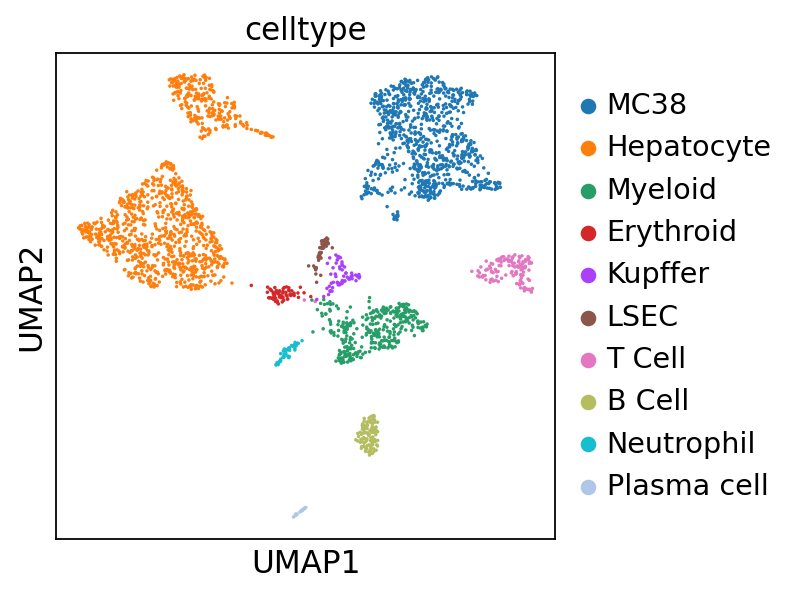

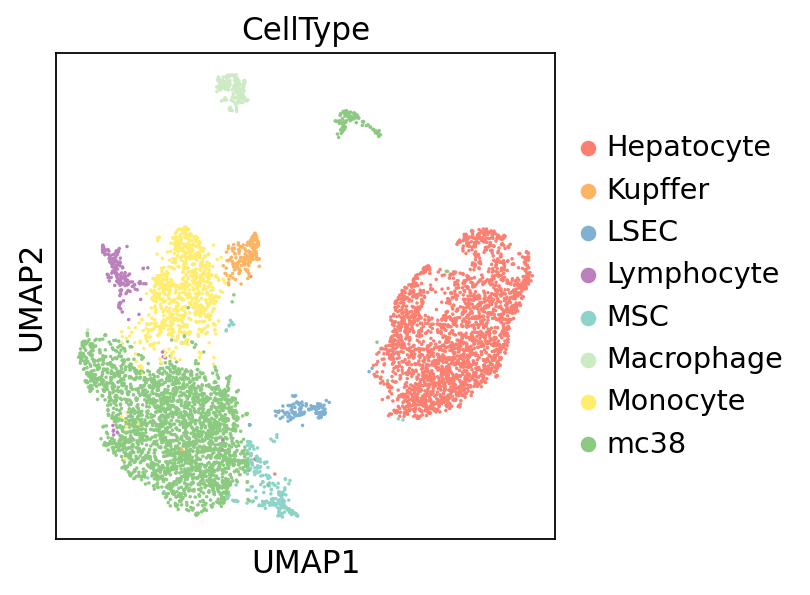

In [25]:
sc.pl.umap(adata_10x,color=['celltype'], size=10)
sc.pl.umap(adata_xyz,color=['CellType',], size=10)

In [33]:
ctdict = dict()
ctdict['Myeloid'] = ['Macrophage', 'Monocyte']
# ctdict['XYZ_Monocyte'] = ['Monocyte']
ctdict['MC38'] = ['mc38']
ctdict['Kupffer'] = ['Kupffer']
ctdict['LSEC'] = ['LSEC']
ctdict['Lymphocyte'] = ['Lymphocyte']
ctdict['Hepatocyte'] = ['Hepatocyte']
ctdict['MSC'] = ['MSC']

adata_xyz.obs['celltype'] = adata_xyz.obs['CellType']
for ct in ctdict:
    for clust in ctdict[ct]:
        adata_xyz.obs['celltype'].replace(clust, ct, regex=True, inplace=True)
adata_xyz.obs['celltype'] = adata_xyz.obs['celltype'].astype('category')

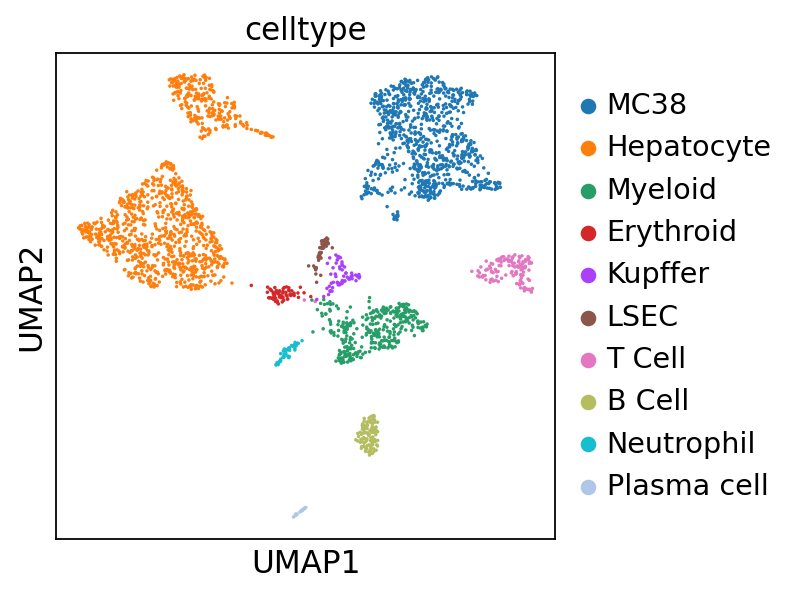

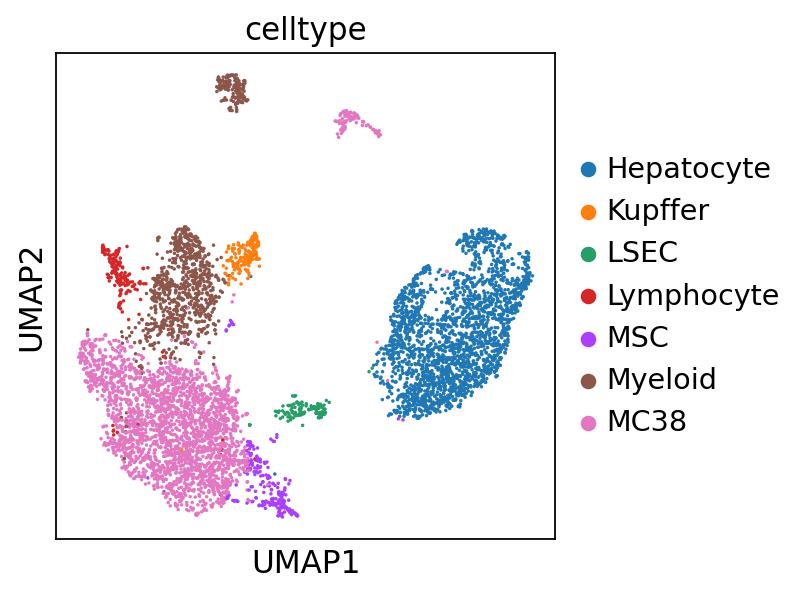

In [35]:
sc.pl.umap(adata_10x,color=['celltype'], size=10)
sc.pl.umap(adata_xyz,color=['celltype'], size=10)

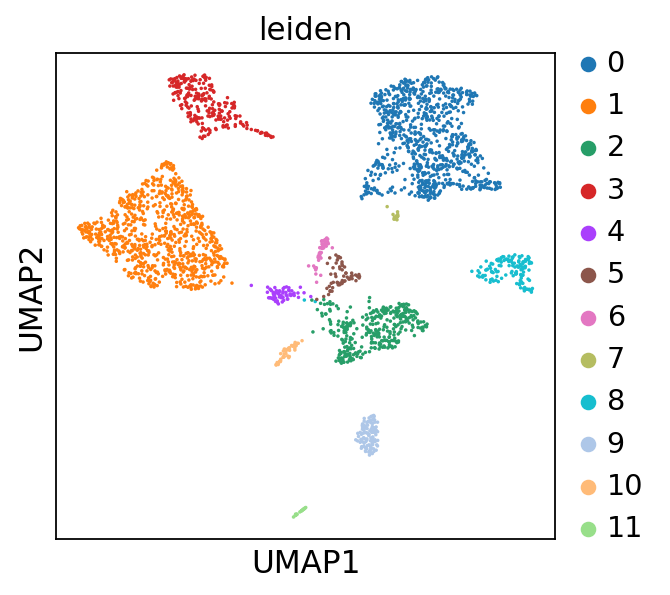

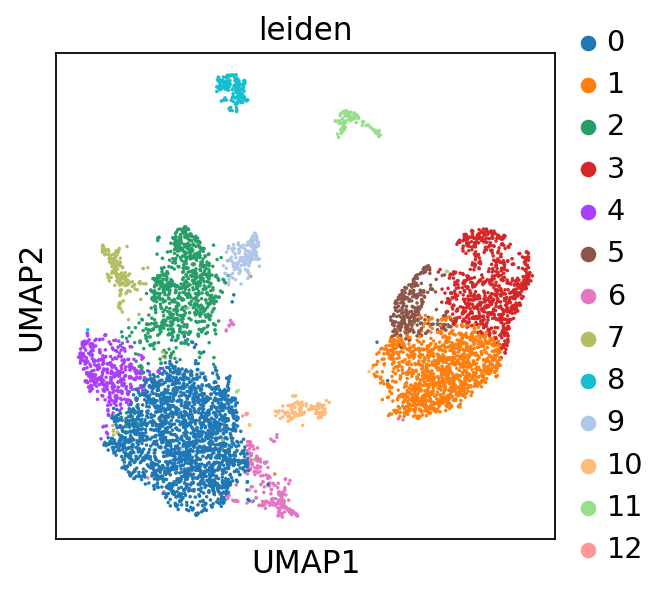

In [26]:
sc.pl.umap(adata_10x,color=['leiden'], size=10, palette=sc.pl.palettes.default_20),# save='.10x.down.leiden.svg')
sc.pl.umap(adata_xyz,color=['leiden',], size=10, palette=sc.pl.palettes.default_20)#, save='.xyz.decontam.leiden.svg')

After exploring in `spatial/notebooks/10x/5prime_liver/check.10x.down.xyz.decontam.de.ipynb`, I'm only going to focus on certain cell types.

In [36]:
cts_10x = ['MC38', 'Hepatocyte', 'Kupffer', 'LSEC', 'T Cell', 'Myeloid']
# cts_xyz = ['Hepatocyte', 'Kupffer', 'LSEC', 'Lymphocyte', 'Macrophage', 'Monocyte', 'mc38']
# cts_xyz = ['Hepatocyte', 'Kupffer', 'LSEC', 'Lymphocyte', 'Monocyte', 'mc38']
cts_xyz = ['Hepatocyte', 'Kupffer', 'LSEC', 'Lymphocyte', 'Myeloid', 'MC38']

In [37]:
adata_10x_focus = adata_10x[adata_10x.obs['celltype'].isin(cts_10x)].copy()
adata_xyz_focus = adata_xyz[adata_xyz.obs['celltype'].isin(cts_xyz)].copy()

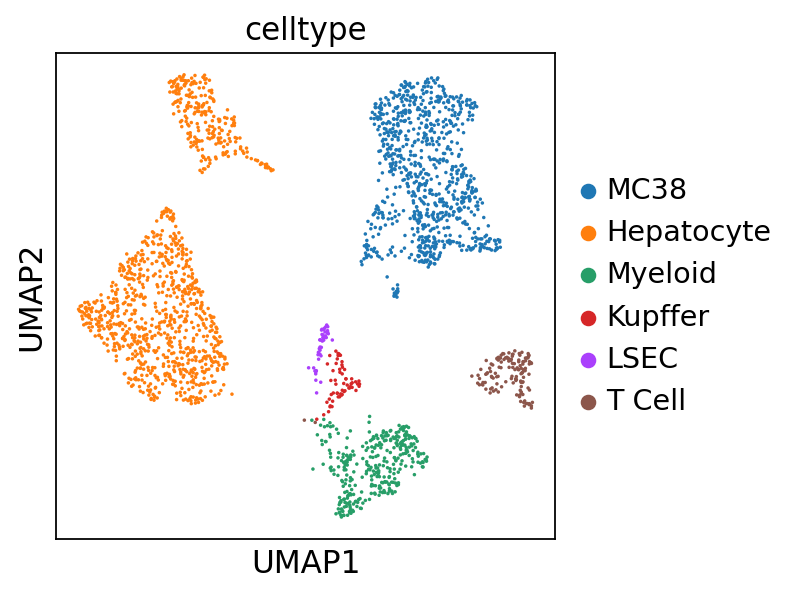

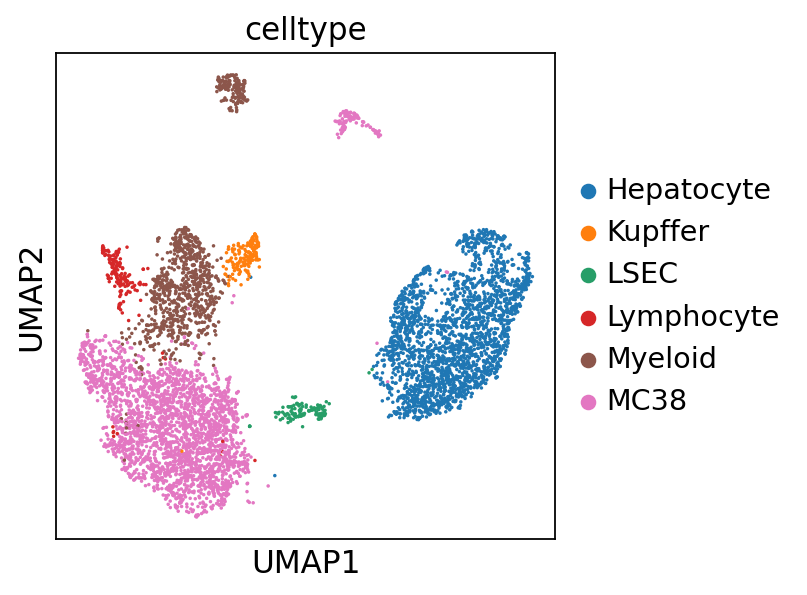

In [38]:
sc.pl.umap(adata_10x_focus,color=['celltype'], size=10)
sc.pl.umap(adata_xyz_focus,color=['celltype',], size=10)

In [40]:
ctdict = dict()
for ct in adata_10x_focus.obs['celltype']:
    ctdict['10X_%s' % ct] = [ct]

for ct in ctdict:
    for clust in ctdict[ct]:
        adata_10x_focus.obs['celltype'].replace(clust, ct, regex=True, inplace=True)
adata_10x_focus.obs['celltype'] = adata_10x_focus.obs['celltype'].astype('category')

In [39]:
ctdict = dict()
for ct in adata_xyz_focus.obs['celltype']:
    ctdict['XYZ_%s' % ct] = [ct]

for ct in ctdict:
    for clust in ctdict[ct]:
        adata_xyz_focus.obs['celltype'].replace(clust, ct, regex=True, inplace=True)
adata_xyz_focus.obs['celltype'] = adata_xyz_focus.obs['celltype'].astype('category')

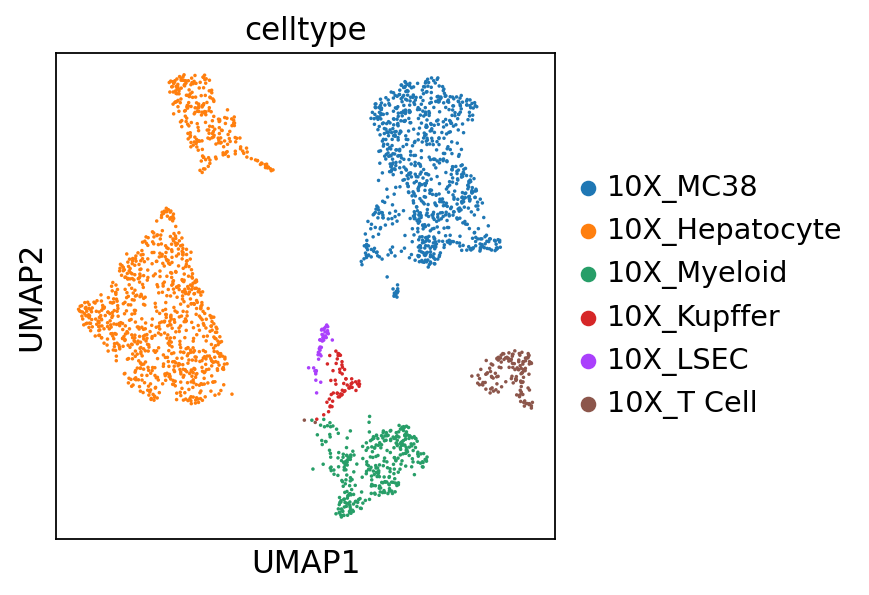

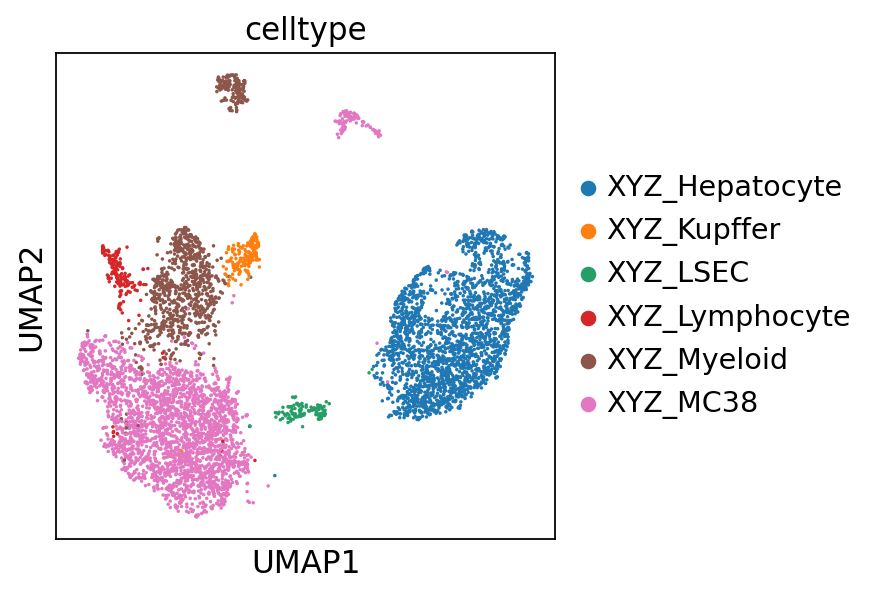

In [41]:
sc.pl.umap(adata_10x_focus,color=['celltype'], size=10)
sc.pl.umap(adata_xyz_focus,color=['celltype',], size=10)

### Cell Type Correlations

In [42]:
adata_xyz_focus_unscaled = sc.pp.normalize_per_cell(adata_xyz_focus.raw.to_adata(), counts_per_cell_after=1e6, copy=True)

normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


Scanpy thinks the data is logged but it's not. Removing this key from the `.uns` to not confuse it.

In [43]:
adata_10x_focus_raw = adata_10x_focus.raw.to_adata()
del(adata_10x_focus_raw.uns['log1p'])
adata_10x_focus_unscaled = sc.pp.log1p(sc.pp.normalize_per_cell(adata_10x_focus_raw, counts_per_cell_after=1e6, copy=True), copy=True)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [44]:
adata_10x_focus_unscaled.var_names

Index(['Mrpl15', 'Lypla1', 'Tcea1', 'Rgs20', 'Atp6v1h', 'Rb1cc1', 'Pcmtd1',
       'Rrs1', 'Adhfe1', 'Vcpip1',
       ...
       'mt-Nd6', 'mt-Cytb', 'Vamp7', 'AC133103.1', 'Csprs', 'AC168977.2',
       'AC168977.1', 'AC149090.1', 'CAAA01118383.1', 'CAAA01147332.1'],
      dtype='object', length=9776)

In [45]:
adata_xyz_focus_unscaled.var_names

Index(['FAM138A', 'OR4F5', 'RP11-34P13.7', 'AL627309.1', 'RP11-34P13.14',
       'AP006222.2', 'RP4-669L17.10', 'OR4F29', 'RP4-669L17.2',
       'RP5-857K21.15',
       ...
       'Ccl19-1', 'AC125178.2', 'AC125149.3', 'AC125149.1', 'AC168977.2',
       'AC168977.1', 'PISD-1', 'DHRSX-1', 'Vmn2r122', 'CAAA01147332.1'],
      dtype='object', length=55287)

In [46]:
print(len(adata_10x_focus_unscaled.var_names))
print(len(adata_xyz_focus_unscaled.var_names))

9776
55287


In [47]:
print(adata_xyz_focus_unscaled.obs.columns)
print(adata_10x_focus_unscaled.obs.columns)

Index(['batch', 'n_counts', 'log_counts', 'n_genes', 'barcode',
       'percent_mito_mouse', 'percent_mito_human', 'mouse_counts',
       'human_counts', 'ratio', 'cell_call', 'contam_init', 'tsne_density',
       'leiden', 'CellType', '__is_in_cluster__', 'celltype'],
      dtype='object')
Index(['mouse_counts', 'human_counts', 'percent_mito', 'n_counts', 'leiden',
       'celltype'],
      dtype='object')


In [48]:
# genes = np.intersect1d(adata_xyz_focus_unscaled.var_names, adata_10x_focus_unscaled.var_names)

In [49]:
sc.settings.verbosity = 0 
warnings.filterwarnings('ignore')
sc.tl.rank_genes_groups(adata_xyz_focus, groupby='celltype', n_genes=1000)
sc.tl.rank_genes_groups(adata_10x_focus, groupby='celltype', n_genes=1000)
warnings.filterwarnings('default')
sc.settings.verbosity = 4

In [50]:
cts_10x = adata_10x_focus.obs['celltype'].unique()
genes_10x = np.concatenate([adata_10x_focus.uns['rank_genes_groups']['names'][ct][:200] for ct in cts_10x])
genes_10x = np.unique(genes_10x)

cts_xyz = adata_xyz_focus.obs['celltype'].unique()
genes_xyz = np.concatenate([adata_xyz_focus.uns['rank_genes_groups']['names'][ct][:200] for ct in cts_xyz])
genes_xyz = np.unique(genes_xyz)

In [51]:
genes = np.intersect1d(genes_10x, genes_xyz)

In [52]:
genes.shape

(338,)

In [53]:
adata_xyz_focus_unscaled_genes = adata_xyz_focus_unscaled[:,genes].copy()
adata_10x_focus_unscaled_genes = adata_10x_focus_unscaled[:,genes].copy()

In [54]:
# Code taken from https://github.com/yelabucsf/lupus_1M_cells_clean/blob/master/figure6_flare/Figure6Flare.V6.ipynb
def marker_gene_expression(anndata, marker_dict, gene_symbol_key=None, partition_key='louvain_r1'):
    """A function go get mean z-score expressions of marker genes
    #
    # Inputs:
    #    anndata        - An AnnData object containing the data set and a partition
    #    marker_dict     - A dictionary with cell-type markers. The markers should be stores as anndata.var_names or
    #                   an anndata.var field with the key given by the gene_symbol_key input
    #    gene_symbol_key - The key for the anndata.var field with gene IDs or names that correspond to the marker
    #                   genes
    #    partition_key   - The key for the anndata.obs field where the cluster IDs are stored. The default is
    #                   'louvain_r1' """

    print("Testing inputs...")
    # Test inputs
    if partition_key not in anndata.obs.columns.values:
        print('KeyError: The partition key was not found in the passed AnnData object.')
        print('   Have you done the clustering? If so, please pass the cluster IDs with the AnnData object!')
        raise

    if (gene_symbol_key != None) and (gene_symbol_key not in anndata.var.columns.values):
        print('KeyError: The provided gene symbol key was not found in the passed AnnData object.')
        print('   Check that your cell type markers are given in a format that your anndata object knows!')
        raise

    if gene_symbol_key:
        gene_ids = anndata.var[gene_symbol_key]
    else:
        gene_ids = anndata.var_names
    
    print("Building DataFrame...")
    clusters = anndata.obs[partition_key].cat.categories
    n_clust = len(clusters)
    marker_exp = pd.DataFrame(columns=clusters)
    marker_exp['cell_type'] = pd.Series({}, dtype='str')
    marker_names = []
    
    print("Z Scoring...")
    z_scores = sc.pp.scale(anndata, copy=True)
    
    print("Finding columns, getting means...")
    i = 0
    for group in marker_dict:
        # Find the corresponding columns and get their mean expression in the cluster
        for gene in tqdm(marker_dict[group]):
            ens_idx = np.in1d(gene_ids, gene) #Note there may be multiple mappings
            if np.sum(ens_idx) == 0:
                continue
            else:
                z_scores.obs[ens_idx[0]] = z_scores.X[:,ens_idx].mean(1) #works for both single and multiple mapping
                ens_idx = ens_idx[0]

            clust_marker_exp = z_scores.obs.groupby(partition_key)[ens_idx].apply(np.mean).tolist()
            clust_marker_exp.append(group)
            marker_exp.loc[i] = clust_marker_exp
            marker_names.append(gene)
            i+=1

    # Replace the rownames with informative gene symbols
    marker_exp.index = marker_names

    return(marker_exp)

In [55]:
marker_dictionary = pd.DataFrame({"all": genes})

In [56]:
marker_exp_10x = marker_gene_expression(adata_10x_focus_unscaled_genes, marker_dictionary, partition_key="celltype")

Testing inputs...
Building DataFrame...
Z Scoring...
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
Finding columns, getting means...


In [57]:
marker_exp_xyz = marker_gene_expression(adata_xyz_focus_unscaled_genes, marker_dictionary, partition_key="celltype")

Testing inputs...
Building DataFrame...
Z Scoring...
Finding columns, getting means...


In [58]:
exp_result = pd.concat([marker_exp_10x, marker_exp_xyz], axis=1, join='inner')

In [59]:
exp_result.columns

Index(['10X_MC38', '10X_Hepatocyte', '10X_Myeloid', '10X_Kupffer', '10X_LSEC',
       '10X_T Cell', 'cell_type', 'XYZ_Hepatocyte', 'XYZ_Kupffer', 'XYZ_LSEC',
       'XYZ_Lymphocyte', 'XYZ_Myeloid', 'XYZ_MC38', 'cell_type'],
      dtype='object')

In [80]:
# exp_result = exp_result[['10X_MC38', '10X_Hepatocyte', '10X_Macrophage', '10X_Kupffer', '10X_LSEC', '10X_T Cell',
#                          'XYZ_MC38', 'XYZ_Hepatocyte', 'XYZ_Macrophage/Monocyte', 'XYZ_Kupffer', 'XYZ_LSEC', 'XYZ_Lymphocyte']]

In [60]:
# exp_result = exp_result[['10X_MC38', '10X_Hepatocyte', '10X_Macrophage', '10X_Kupffer', '10X_LSEC', '10X_T Cell',
#                          'XYZ_MC38', 'XYZ_Hepatocyte', 'XYZ_Monocyte', 'XYZ_Kupffer', 'XYZ_LSEC', 'XYZ_Lymphocyte']]
exp_result = exp_result[['10X_MC38', '10X_Hepatocyte', '10X_Myeloid', '10X_Kupffer', '10X_LSEC', '10X_T Cell',
                         'XYZ_MC38', 'XYZ_Hepatocyte', 'XYZ_Myeloid', 'XYZ_Kupffer', 'XYZ_LSEC', 'XYZ_Lymphocyte']]

In [61]:
exp_corr = exp_result.corr()

In [62]:
exp_corr = exp_corr.iloc[:6,-6:]

In [65]:
mask = np.zeros_like(exp_corr)
mask[np.triu_indices_from(mask, k=1)] = True
g = sns.clustermap(exp_corr, 
                   mask=mask, 
                   yticklabels=True, 
                   xticklabels=True, 
                   row_cluster=False, 
                   col_cluster=False,
                   annot=True, fmt='04.2f',
                   figsize=(10,10)
                  );

# In case you want to add to the other, empty triangle of the heatmap
# for i, j in it.product(range(exp_corr.shape[0]), range(exp_corr.shape[0])):
#     if i > j:
#         continue
#     else:
#         pos_x = i + 0.5
#         pos_y = j + 0.5
#         g.ax_heatmap.text(pos_x,pos_y,
#                           '{:04.2f}'.format(exp_corr.iloc[i,j]), 
#                           fontsize=10, horizontalalignment='center')



g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=45, ha='right');
g.ax_heatmap.yaxis.set_label_position("left")
g.ax_heatmap.yaxis.tick_left()
plt.tight_layout()
# g.savefig("/data/xyzeq/figures/10X.down.XYZ.decontam/gh.for.youjin.12OCT20/3C/heatmap.myeloid.combined.svg")
plt.close()